# Objective

The purpose of this notebook is to explore weekly rain event counts (days with $\ge .02mm$ of precipitation) to understand changes and trends over time. Once we have an understanding of the properties of the time series, we'll explore univariate time series models to predict how many rain events we can expect in the following week.

# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../src'))

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import itertools
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from app.model.baseline_models import evalute_model, score, predict_naive, predict_snaive, predict_ma
from app.model.diagnostics import display_results

%matplotlib inline

warnings.simplefilter('ignore')

# Data

In [4]:
weekly_counts = pd.read_csv('../data/processed/weekly-rain-day-counts.csv', parse_dates=['date']).set_index('date')
weekly_counts.head()

,rainEvents
date,
2009-12-27,3
2010-01-03,4
2010-01-10,1
2010-01-17,2
2010-01-24,6


# Time Series Analysis

## Entire history

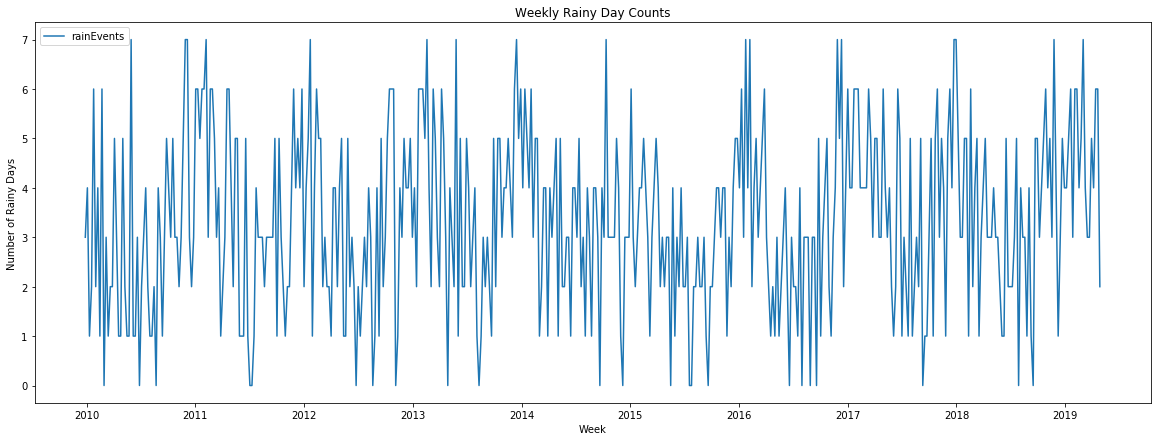

In [5]:
plt.figure(figsize=(20,7))
sns.lineplot(data=weekly_counts).set(
  title='Weekly Rainy Day Counts',
  xlabel='Week',
  ylabel='Number of Rainy Days');

It looks like there is some clear seasonality here - rainy day counts spike at the beginning of the year (here, precipitation is mostly snow) and drop by around June. As observed in the exploratory analysis, 2015-2017 experienced lower counts in the summer months. Since 2017, we have seen more weekly rain events.

In [6]:
pre_2017, post_2017 = weekly_counts[:'2016-12-31'], weekly_counts['2017-01-01':]
mean_pre_2017, mean_post_2017 = pre_2017.mean().values[0], weekly_counts['2017-01-01':].mean().values[0]

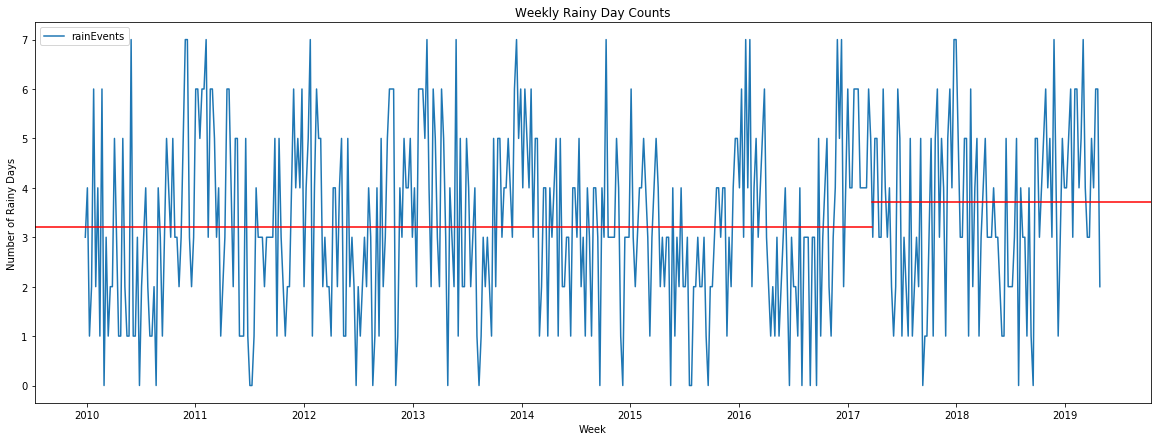

In [7]:
plt.figure(figsize=(20,7))
sns.lineplot(data=weekly_counts).set(
  title='Weekly Rainy Day Counts',
  xlabel='Week',
  ylabel='Number of Rainy Days');
plt.axhline(mean_pre_2017, xmin=0, xmax=len(pre_2017) / len(weekly_counts), color='red')
plt.axhline(mean_post_2017, xmin=len(pre_2017) / len(weekly_counts), xmax=1, color='red')

With the change in mean weekly event count over time, our model will need to give more weight to more recent observations.

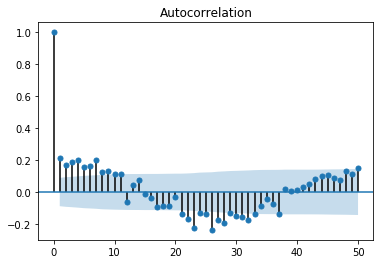

In [8]:
plot_acf(weekly_counts, lags=50);

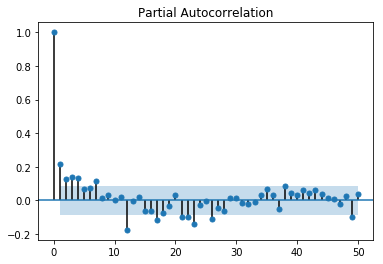

In [9]:
plot_pacf(weekly_counts, lags=50);

Likely many different lags with statistically significant autocorrelations due to the long history of observations (i.e. differently autocorellations at different points in time). Negative correlation is likely explained by the seasonality we see every half year (~26 weeks). What about over the last two years?

## Last two years

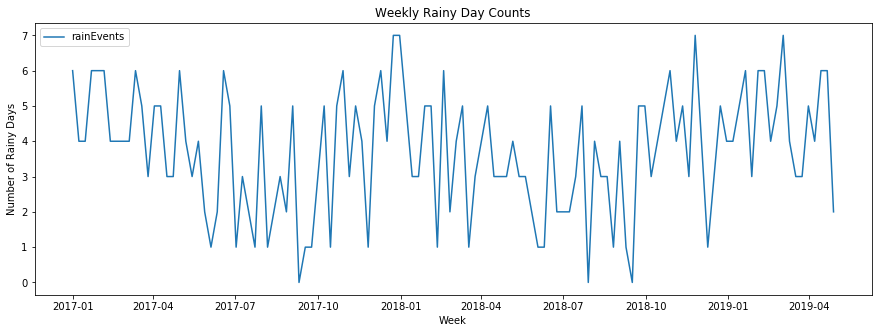

In [10]:
plt.figure(figsize=(15,5))
sns.lineplot(data=weekly_counts['2017-01-01':]).set(
  title='Weekly Rainy Day Counts',
  xlabel='Week',
  ylabel='Number of Rainy Days');

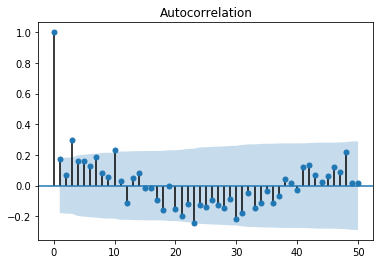

In [11]:
plot_acf(weekly_counts['2017-01-01':], lags=50);

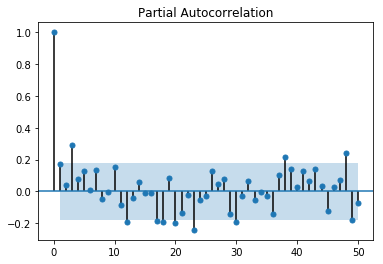

In [12]:
plot_pacf(weekly_counts['2017-01-01':], lags=50);

## By year

In [13]:
weekly_counts_df = weekly_counts.assign(
  year=lambda x: x.index.year, 
  month=lambda x: x.index.month, 
  week=lambda x: x.index.week).reset_index()
weekly_counts_df.head()

,date,rainEvents,year,month,week
0,2009-12-27,3,2009,12,52
1,2010-01-03,4,2010,1,53
2,2010-01-10,1,2010,1,1
3,2010-01-17,2,2010,1,2
4,2010-01-24,6,2010,1,3


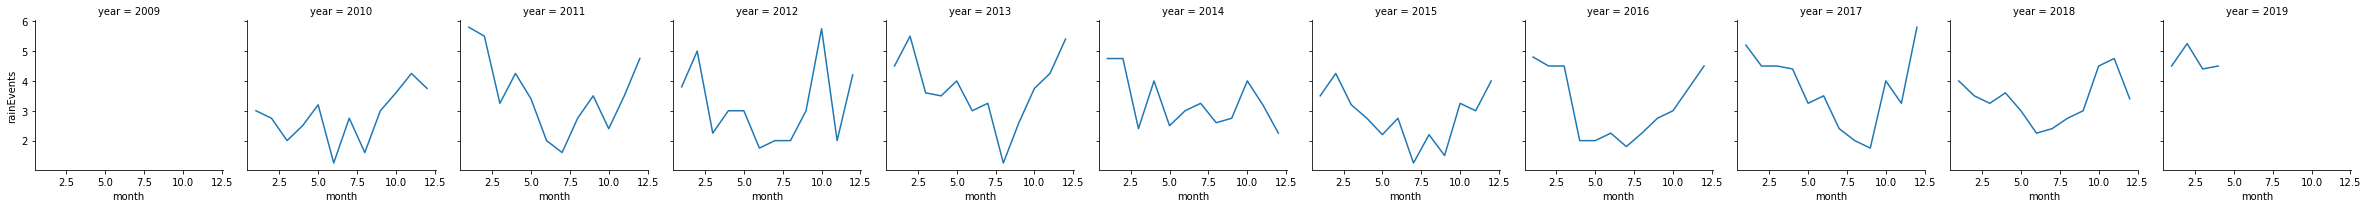

In [14]:
g = sns.FacetGrid(weekly_counts_df, col='year')
g.map(sns.lineplot, 'month', 'rainEvents', ci=None);

It looks like if we take the seasonal naive forecasts, we'd have good luck especially over the last three years.

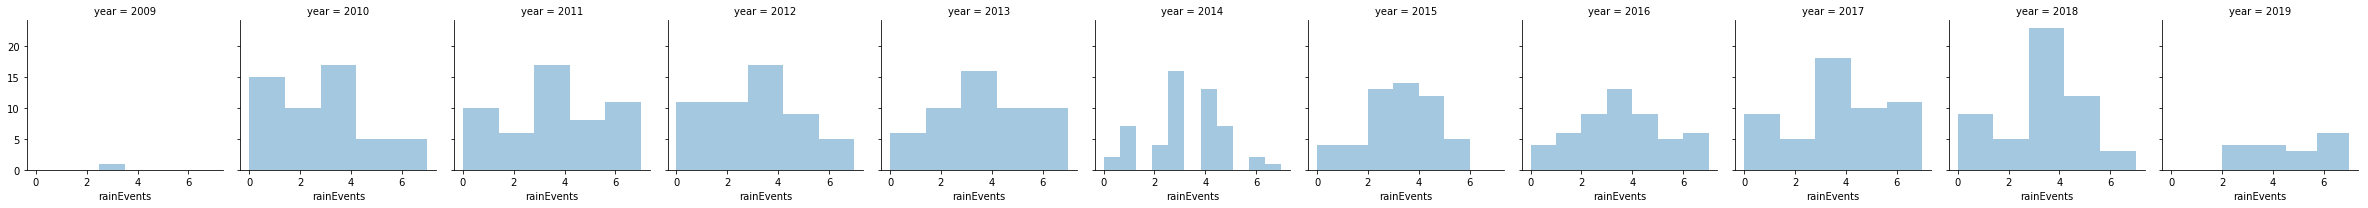

In [15]:
g = sns.FacetGrid(weekly_counts_df, col='year')
g.map(sns.distplot, 'rainEvents', kde=False);

The distributions appear similar over the last few years (2015-2018).

## Decomposition

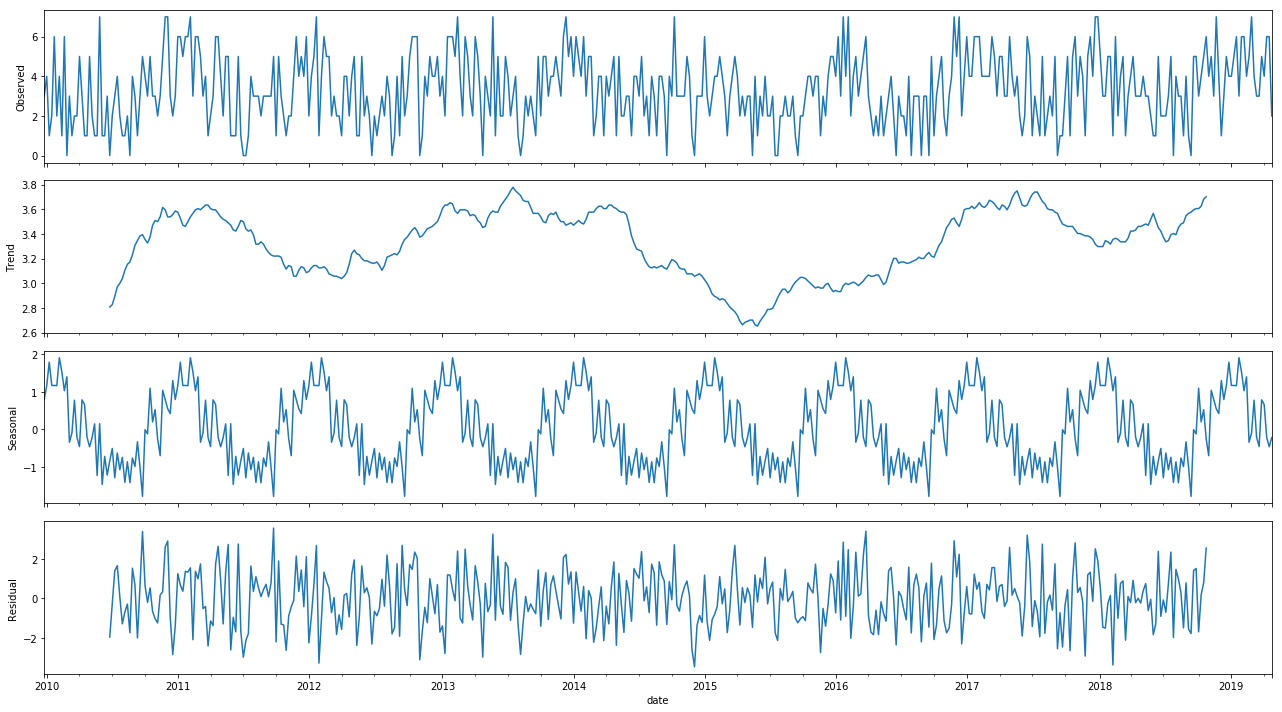

In [16]:
with mpl.rc_context():
  mpl.rc("figure", figsize=(18,10))
  sd = seasonal_decompose(weekly_counts, model='additive')
  sd.plot();

There is clear seasonality as we would expect and it looks like there was a regime change following 2015. It looks like there is a cycle that lasts ~4 years during which time the average number of rainy days per week gradually decreases (sharply in the case of 2014). There has been a sharp upturn since the middle of 2018.

# Models

## Naive

Uses the prior week rain day count to predict current week rain day count.

Naive Score: 1.7597535934291582


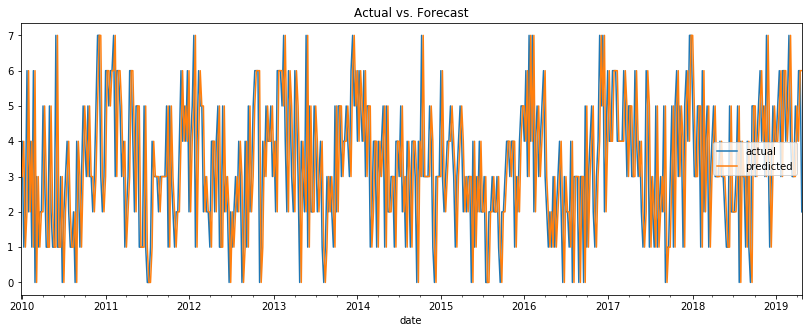

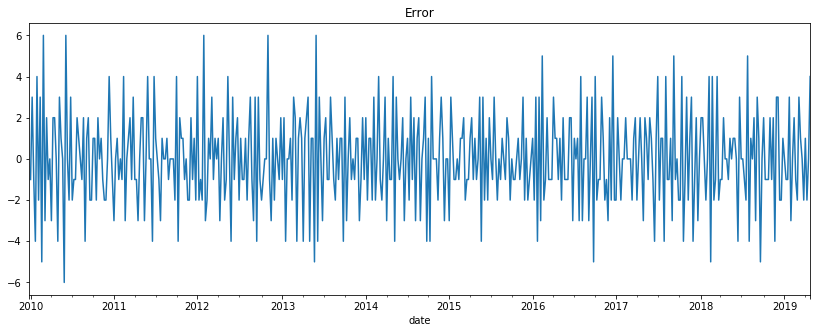

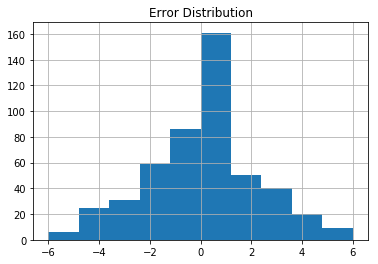

Error stats:
count    487.000000
mean       0.002053
std        2.222684
min       -6.000000
25%       -1.000000
50%        0.000000
75%        1.000000
max        6.000000
Name: Naive, dtype: float64


In [18]:
naive_result = evalute_model('Naive', predict_naive, weekly_counts)
display_results(naive_result)

There is still seasonality in the errors so we can do better than a random walk model.

## Seasonal Naive

Uses the previous year's rainy day count as the forecast for this year's count.

Seasonal Naive Score: 1.761467889908257


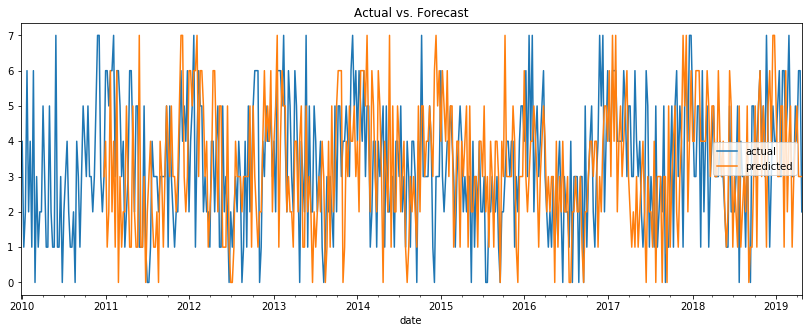

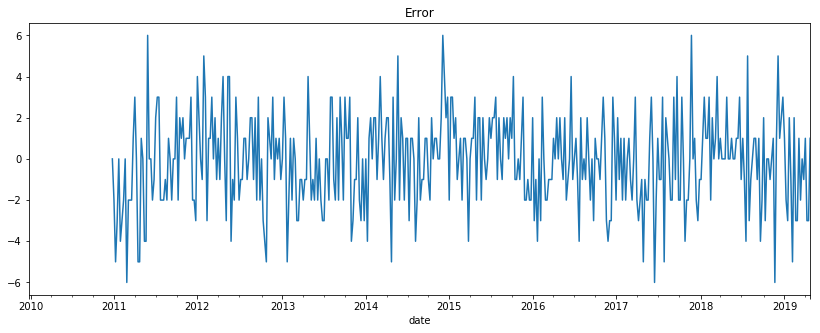

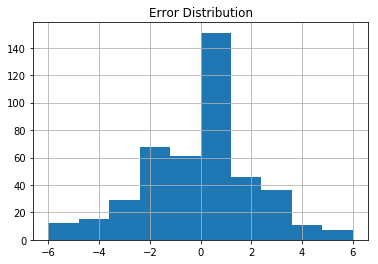

Error stats:
count    436.000000
mean      -0.105505
std        2.214449
min       -6.000000
25%       -2.000000
50%        0.000000
75%        1.000000
max        6.000000
Name: Seasonal Naive, dtype: float64


In [19]:
snaive_result = evalute_model('Seasonal Naive', predict_snaive, weekly_counts)
display_results(snaive_result)

The score is worse for the seasonal model than the naive model and the errors appear even more correlated.

## Moving Average

Building MA model, k=2 Score=1.6127049180327868
Building MA model, k=3 Score=1.5471311475409837
Building MA model, k=4 Score=1.4979508196721312
Building MA model, k=5 Score=1.4774590163934427
Building MA model, k=6 Score=1.485655737704918
Building MA model, k=7 Score=1.4918032786885247
Building MA model, k=8 Score=1.4877049180327868
Building MA model, k=9 Score=1.4651639344262295
Building MA model, k=10 Score=1.4405737704918034
Building MA model, k=11 Score=1.4467213114754098
Building MA model, k=12 Score=1.4795081967213115
Building MA model, k=13 Score=1.4918032786885247
Building MA model, k=14 Score=1.4836065573770492
Building MA model, k=15 Score=1.5020491803278688
Building MA model, k=16 Score=1.5122950819672132
Building MA model, k=17 Score=1.5389344262295082
Building MA model, k=18 Score=1.540983606557377
Building MA model, k=19 Score=1.5532786885245902
Building MA model, k=20 Score=1.5594262295081966
Building MA model, k=21 Score=1.569672131147541
Building MA model, k=22 Score=1

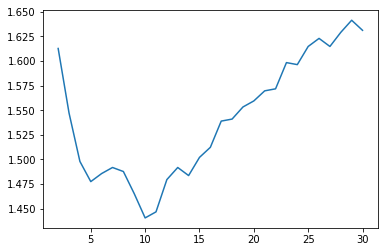

In [20]:
ma_results = []
ks = np.arange(2, 31)

for k in ks:
  print(f'Building MA model, k={k}', end=' ')
  preds = predict_ma(weekly_counts, k)
  error = weekly_counts.iloc[:,0] - preds
  model_score = score(error)
  ma_results.append(model_score)
  print(f'Score={model_score}')
  
plt.plot(range(2, 31), ma_results);

In [21]:
best_k = ks[np.argmin(ma_results)]
print('Best value for k:', best_k)

Best value for k: 10


Moving Average (k=10) Score: 1.6127049180327868


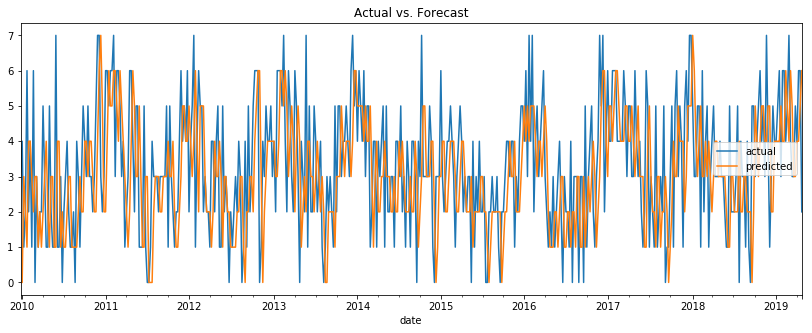

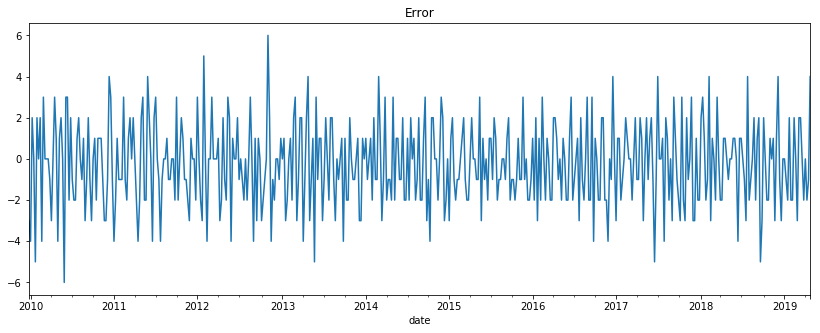

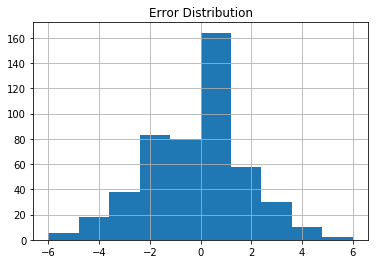

Error stats:
count    488.000000
mean      -0.264344
std        1.995323
min       -6.000000
25%       -2.000000
50%        0.000000
75%        1.000000
max        6.000000
Name: Moving Average (k=10), dtype: float64


In [22]:
ma_result = evalute_model(f'Moving Average (k={best_k})', predict_ma, weekly_counts, k=best_k)
display_results(ma_result)

A significant improvement over the naive models